# Example of using The Module Formerly Known as KDE and Asy_peakbag
This is a notebook showing a rough draft of the replacement module for KDE and Asy_peakbag, which is currently WIP on the PBjam-dev branch.

We'll start by importing the modeID sampler (Should the name be changed?)

In [2]:
#%load_ext autoreload
#%autoreload 2
from pbjam.modeID import modeIDsampler
from pbjam import IO
import pbjam.distributions as dist
import matplotlib.pyplot as plt
import astropy.convolution as conv
import numpy as np

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
psd = IO.psd('KIC9414417', lk_kwargs={'exptime': 60, 'mission':'Kepler', 'author':'Kepler'})

psd()

f = psd.freq[::2]

s = psd.powerdensity[::2]

Using cached search result.
Loading fits files from cache.


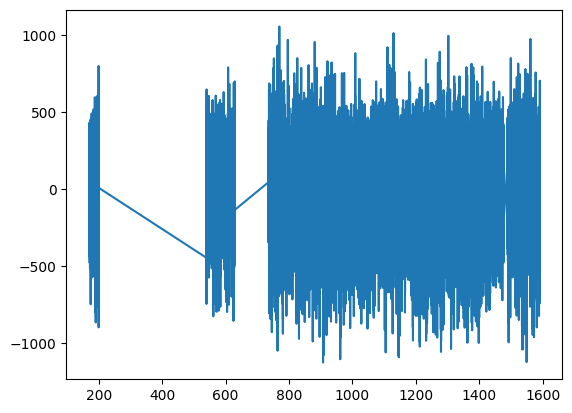

In [4]:
plt.plot(psd._time, psd._flux)

In [5]:

addPriors = {'p_L0': dist.normal(loc=np.log10(0.024), scale=0.1),
             'p_D0': dist.normal(loc=np.log10(0.0036), scale=0.1),
             'DPi0': dist.normal(loc=np.log10(0.000476), scale=0.1),
             'eps_g': dist.normal(loc=0.81, scale=0.01),
             'd01': dist.normal(loc=np.log10(26), scale=0.1),
             'alpha_g': dist.normal(loc=np.log10(0.02), scale=0.1),
            }

These location and scale parameters for the priros are suitable for a cool MS star. The g-mode parameters are of course non-sense, and all fits to MS stars just recover this prior since the p-modes can't feel any of the g-modes yet. For lower numax targets, the prior parameters must be chosen by hand (see the bottom of this notebook).

The pbjam.distributions module contains a short list of 'standard' distributions,these include normal, uniform, beta and a few others.. The jax.scipy.stats module could replace some of these functions, but they are far from complete (many don't have a ppf method for example). If you want to construct your own distribution you can do so, although it must have a ppf method which is required by Dynesty.

If you wish to add a distribution as a prior, you'll need to use the correct keyword as everything is now keyword-based rather than index-based. You can view a list of all keywords for the model parameters, whether they are treated in log10 or not and whether they are included in the DR by default in the `modeIDsampler.variables` attribute of the sampler class. You can edit this before initializing the class below in case you want to set a parameter to log10, but you won't need to edit things if you're just adding priors. This will be handled automatically. **Ideally you won't need to edit this at all**

Apart from those listed above, the shot noise and the very lowest frequency harvey law have hardcoded priors. It's safe to ignore these for now. 

## Additional observational parameters
As in the earlier PBjam versions we use additional observational parameters. $\nu_{max}$, $\Delta\nu$ and $T_{eff}$ are used to select the prior sub-sample to construct the covariance matrix for DR, while $T_{eff}$ and $G_{bp}-G_{rp}$ are used in the actual sampling as additional log-likelihood terms.

In [7]:
addObs = {'numax': (1125.243854, 100),
          'dnu'  : (59.936120, 0.54),
          'teff' : (6278.0, 77),
          'bp_rp': (0.662909, 0.05),
          } 

## Initialize the sampler
We can now initialize the sampler class. This requires specifying the number of orders `N_p` (previously `norders`) to include in the model. In addition we also set the number of targets (`N_pca`) to draw from the prior sample to construct covariance matrix for DR, and the number of dimensions (`PCAdims`) to use in the sampling.  

TODO: add in a check that `PCAdims` + non-PCA dims <= all model parameters.

In [8]:
N_p = 8

N_pca = 100

PCAdims = 8
 
M = modeIDsampler(f, s, addObs, addPriors, N_p=N_p, Npca=N_pca, PCAdims=PCAdims, priorpath=IO.get_priorpath(), freq_limits=[3,5000])

## Plot the prior
It's always good to check that your prior is reasonable, so lets plot some samples from the prior.

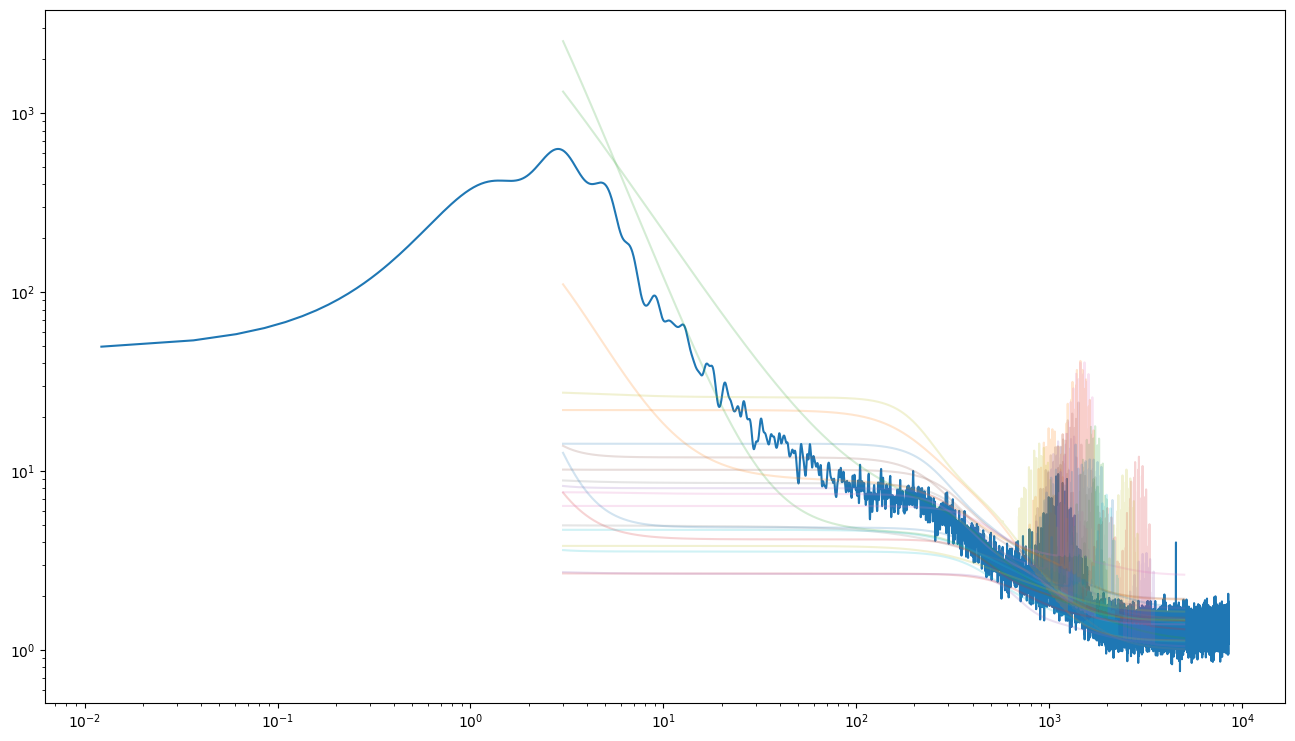

In [9]:


fac = max([1, 0.5 / (M.f[1] - M.f[0])])
kernel = conv.Gaussian1DKernel(stddev=np.array(fac))
smoo = conv.convolve(M.s, kernel)

N = 20

fig, ax = plt.subplots(figsize=(16,9))

ax.loglog(M.f, smoo)

for i in range(N):
    u = np.random.uniform(0, 1, size=M.ndims)

    theta = M.ptform(u)
    
    theta_u = M.unpackParams(theta)
     
    m = M.model(theta_u, M.f)
    
    ax.loglog(M.f[M.sel], m[M.sel], alpha = 0.2)

## Run Dynesty
Time to run! You can optionally run with the dynamic sampler enabled, but it probably won't do you much good and take an order of magnitude longer.

In [ ]:
sampler, samples = M(nlive=300)

15724it [29:38,  8.67it/s, bound: 346 | nc: 40 | ncall: 597018 | eff(%):  2.634 | loglstar:   -inf < -328257.532 <    inf | logz: -328313.049 +/-  0.426 | dlogz: 96.759 >  0.309] 

## Plot model samples
Time to plot some of the posterior samples

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(M.f, smoo)
 
N = 20
for i in np.random.randint(0, samples.shape[0], size=N):
    
    theta = samples[i, :]

    theta_u = M.unpackParams(theta)
     
    m = M.model(theta_u, M.f)
    
    ax.plot(M.f, m, color='C3', alpha=0.25)
    
ax.set_yscale('log')
ax.set_xscale('log')


fig, ax = plt.subplots(figsize=(16,9))
ax.plot(M.f, smoo)
 
for i in np.random.randint(0, samples.shape[0], size=N):
    
    theta = samples[i, :]

    theta_u = M.unpackParams(theta)
     
    m = M.model(theta_u, M.f)
    
    ax.plot(M.f, m, color='C3', alpha=0.25)
ax.set_xlim(addObs['numax'][0]-7*addObs['dnu'][0], addObs['numax'][0]+7*addObs['dnu'][0])
ax.set_ylim(0, 50)

## Corner plot
We can make a nice corner plot too. However, the samples from the priors contain a mix of latent parameters and model parameters, some in log10, others not. To get everything in terms of linear model parameters we'll need to transform the raw samples

In [ ]:
samples_u = M.unpackSamples(samples)

In [ ]:
import corner
corner.corner(samples_u);

Or any subset.

In [ ]:
corner.corner({k : samples_u[k] for k in ['dnu', 'numax', 'd01', 'DPi0', 'eps_g', 'p_L0', 'p_D0']});

## Parameters for other stars

In [ ]:
# # KIC8524425
# obs = {'teff': (5413, 80),
#        'bp_rp': (0.9026, 0.05), 
#        'numax': (1084.7, 10.0),
#        'dnu': (59.62, 0.21)}


##############
# OUT OF DATE - NEED TO LOG ALL THESE VALUES
##############
# # These parameters are suitable for a cool subgiant at ~1000 muHz.
# addPriors = {'p_L0': dist.normal(loc=0.024, scale=0.1 * 0.024), # First coefficient of coupling strength matrix poly.
#              'p_D0': dist.normal(loc=0.0036, scale=0.1 * 0.0036), # First coefficient of overlap integral matrix poly.
#              'DPi0': dist.normal(loc=0.000476, scale=0.1 * 0.000476), # period spacing in 1/muHz (mega seconds)
#              'eps_g': dist.normal(loc=0.81, scale=0.1 *0.81), # epsilon for g-modes
#              'alpha_g': dist.normal(loc=0.02, scale=0.002), # curvature for g-modes
#              'd01': dist.normal(loc=26, scale=2.6), # absolute l=0,1 spacing in muHz.
#              'nurot_c': dist.uniform(loc=0.01, scale=.05) # Core rotation rate in log(muHz)
#             }


 
       
       